# Topic Modelling using LDA

# To Do:
1) Extend stopwords


2) Take the num_topic corresponding to the best coherence score in the graph


In [1]:
import pandas as pd
import sqlite3
import string
import nltk
con = sqlite3.connect("amazon_product.db")

In [2]:
data = pd.read_sql_query("SELECT * from amazon_product", con)

In [3]:
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree

In [4]:
data['clean_description']= data['description'].apply(lambda x:remove_punctuation(x))

In [5]:
data = data.fillna('')

In [6]:
data['clean_description']= data['clean_description'].apply(lambda x: x.lower())

In [7]:
data1=data

In [8]:
data1.drop(labels=['sku','title','brand','description','aihello_id','last_updated','price','image_url','currency_code','product_category','product_tier','weight','weight_type','height','width','depth','dim_type','rating','user_id','product_inventory_id','amazon_product_estimates_id','fnsku','upc','product_id','product_id_type','ship_international','bullet_points'],inplace=True, axis=1)

In [9]:
data1=data1.iloc[0:100]

In [10]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim_models  # don't skip this
#import matplotlib.pyplot as plt
#%matplotlib inline
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data1['clean_description']))

print(data_words[:1])

[['hindery', 'the', 'ceo', 'of', 'the', 'yes', 'network', 'the', 'new', 'york', 'yankees', 'cable', 'channel', 'has', 'handled', 'some', 'deals', 'in', 'his', 'year', 'career', 'with', 'considerable', 'success', 'along', 'the', 'way', 'hes', 'learned', 'lessons', 'like', 'do', 'more', 'homework', 'than', 'the', 'other', 'guy', 'and', 'read', 'the', 'fine', 'print', 'his', 'book', 'is', 'strongest', 'when', 'he', 'writes', 'of', 'the', 'deals', 'he', 'was', 'part', 'of', 'such', 'as', 'the', 'yes', 'networks', 'troubled', 'creation', 'so', 'much', 'dirt', 'got', 'hurled', 'you', 'could', 'have', 'built', 'new', 'ballfield', 'with', 'it', 'he', 'addresses', 'fundamental', 'business', 'issues', 'but', 'often', 'its', 'the', 'personalities', 'that', 'drive', 'these', 'deals', 'corporate', 'politics', 'are', 'captivating', 'so', 'long', 'as', 'characters', 'like', 'george', 'steinbrenner', 'are', 'involved', 'and', 'hindery', 'boldly', 'names', 'people', 'whove', 'crossed', 'him', 'in', 'th

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['hindery', 'the', 'ceo', 'of', 'the', 'yes', 'network', 'the', 'new_york', 'yankees', 'cable', 'channel', 'has', 'handled', 'some', 'deals', 'in', 'his', 'year', 'career', 'with', 'considerable', 'success', 'along', 'the', 'way', 'hes', 'learned', 'lessons', 'like', 'do', 'more', 'homework', 'than', 'the', 'other', 'guy', 'and', 'read', 'the', 'fine', 'print', 'his', 'book', 'is', 'strongest', 'when', 'he', 'writes', 'of', 'the', 'deals', 'he', 'was', 'part', 'of', 'such', 'as', 'the', 'yes', 'networks', 'troubled', 'creation', 'so', 'much', 'dirt', 'got', 'hurled', 'you', 'could', 'have', 'built', 'new', 'ballfield', 'with', 'it', 'he', 'addresses', 'fundamental', 'business', 'issues', 'but', 'often', 'its', 'the', 'personalities', 'that', 'drive', 'these', 'deals', 'corporate', 'politics', 'are', 'captivating', 'so', 'long', 'as', 'characters', 'like', 'george', 'steinbrenner', 'are', 'involved', 'and', 'hindery', 'boldly', 'names', 'people', 'whove', 'crossed', 'him', 'in', 'the', 

In [14]:
 # Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [18]:
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0.tar.gz

In [19]:
#!pip install --upgrade packaging

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_words[:1])

[['hindery', 'the', 'ceo', 'of', 'the', 'yes', 'network', 'the', 'new', 'york', 'yankees', 'cable', 'channel', 'has', 'handled', 'some', 'deals', 'in', 'his', 'year', 'career', 'with', 'considerable', 'success', 'along', 'the', 'way', 'hes', 'learned', 'lessons', 'like', 'do', 'more', 'homework', 'than', 'the', 'other', 'guy', 'and', 'read', 'the', 'fine', 'print', 'his', 'book', 'is', 'strongest', 'when', 'he', 'writes', 'of', 'the', 'deals', 'he', 'was', 'part', 'of', 'such', 'as', 'the', 'yes', 'networks', 'troubled', 'creation', 'so', 'much', 'dirt', 'got', 'hurled', 'you', 'could', 'have', 'built', 'new', 'ballfield', 'with', 'it', 'he', 'addresses', 'fundamental', 'business', 'issues', 'but', 'often', 'its', 'the', 'personalities', 'that', 'drive', 'these', 'deals', 'corporate', 'politics', 'are', 'captivating', 'so', 'long', 'as', 'characters', 'like', 'george', 'steinbrenner', 'are', 'involved', 'and', 'hindery', 'boldly', 'names', 'people', 'whove', 'crossed', 'him', 'in', 'th

In [17]:
data_words_bigrams

[['hindery',
  'ceo',
  'yes',
  'network',
  'new_york',
  'yankees',
  'cable',
  'channel',
  'handled',
  'deals',
  'year',
  'career',
  'considerable',
  'success',
  'along',
  'way',
  'hes',
  'learned',
  'lessons',
  'like',
  'homework',
  'guy',
  'read',
  'fine',
  'print',
  'book',
  'strongest',
  'writes',
  'deals',
  'part',
  'yes',
  'networks',
  'troubled',
  'creation',
  'much',
  'dirt',
  'got',
  'hurled',
  'could',
  'built',
  'new',
  'ballfield',
  'addresses',
  'fundamental',
  'business',
  'issues',
  'often',
  'personalities',
  'drive',
  'deals',
  'corporate',
  'politics',
  'captivating',
  'long',
  'characters',
  'like',
  'george',
  'steinbrenner',
  'involved',
  'hindery',
  'boldly',
  'names',
  'people',
  'whove',
  'crossed',
  'past',
  'sorts',
  'brilliant',
  'deal',
  'makers',
  'merely',
  'competent',
  'seeking',
  'key',
  'qualities',
  'including',
  'vision',
  'chutzpah',
  'moxie',
  'many',
  'namebrand',
  'ceo

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 4), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 7), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 9), (17, 2), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 2), (29, 2), (30, 1), (31, 1), (32, 1), (33, 5), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 10), (45, 3), (46, 2), (47, 6), (48, 25), (49, 1), (50, 1), (51, 2), (52, 1), (53, 1), (54, 15), (55, 4), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 11), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 33), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 2), (76, 1), (77, 1), (78, 2), (79, 1), (80, 6), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 3), (89, 1), (90, 1), (91, 5), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 3), (98, 1), (99, 6), (100, 2), (101, 3), (102, 1), (103, 1), (104, 1), (105, 3), (106, 1), (107, 1), (108, 1), (109, 1), (11

In [22]:
id2word[0]

'abbreviate'

In [23]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('abbreviate', 1),
  ('ability', 3),
  ('able', 4),
  ('aborted', 1),
  ('aboutface', 1),
  ('abroad', 1),
  ('absent', 2),
  ('accept', 1),
  ('access', 7),
  ('accomplish', 1),
  ('accomplishment', 1),
  ('accord', 2),
  ('accrue', 1),
  ('achieve', 1),
  ('achievement', 1),
  ('acquire', 3),
  ('acquisition', 9),
  ('act', 2),
  ('actual', 1),
  ('actually', 2),
  ('ad', 1),
  ('addictive', 1),
  ('addition', 1),
  ('address', 1),
  ('admirably', 1),
  ('advance', 1),
  ('advantage', 1),
  ('advertising', 2),
  ('affect', 2),
  ('affected', 2),
  ('afghanistan', 1),
  ('afraid', 1),
  ('aftermath', 1),
  ('age', 5),
  ('aggressively', 1),
  ('agree', 1),
  ('ahead', 1),
  ('aid', 1),
  ('airline', 1),
  ('akin', 1),
  ('alarm', 1),
  ('allege', 1),
  ('allen', 1),
  ('allow', 2),
  ('almost', 10),
  ('alone', 3),
  ('along', 2),
  ('already', 6),
  ('also', 25),
  ('alter', 1),
  ('altogether', 1),
  ('always', 2),
  ('amaze', 1),
  ('amazon', 1),
  ('america', 15),
  ('american',

In [24]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.066*"watch" + 0.029*"blade" + 0.025*"design" + 0.021*"tool" + '
  '0.020*"technology" + 0.016*"cut" + 0.015*"time" + 0.013*"make" + '
  '0.012*"edge" + 0.012*"hand"'),
 (1,
  '0.009*"cutout" + 0.002*"ss" + 0.000*"wordperfect_office" + '
  '0.000*"wordperfect" + 0.000*"ttwjpg_width" + 0.000*"qhbs_tb" + 0.000*"kvnt" '
  '+ 0.000*"atvpdkikx_dera" + 0.000*"dera" + 0.000*"classtextblock"'),
 (2,
  '0.015*"video" + 0.014*"audio" + 0.014*"sound" + 0.013*"control" + '
  '0.011*"digital" + 0.009*"dvd" + 0.009*"tv" + 0.009*"include" + '
  '0.008*"system" + 0.008*"input"'),
 (3,
  '0.037*"music" + 0.018*"song" + 0.016*"play" + 0.016*"band" + 0.012*"album" '
  '+ 0.012*"record" + 0.010*"new" + 0.010*"guitar" + 0.008*"jazz" + '
  '0.008*"sound"'),
 (4,
  '0.023*"power" + 0.021*"battery" + 0.018*"vehicle" + 0.017*"system" + '
  '0.017*"protection" + 0.015*"include" + 0.012*"feature" + 0.012*"product" + '
  '0.012*"provide" + 0.010*"install"'),
 (5,
  '0.039*"film" + 0.027*"game" + 0.015*"s

In [34]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.508444413918548

Coherence Score:  0.5024980926052449


In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Applications/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17     0.190798  0.209193       1        1  22.559932
19     0.223360 -0.063699       2        1  11.448937
2      0.227051 -0.029997       3        1   8.858952
6      0.212328 -0.081410       4        1   7.857812
18     0.179556 -0.024908       5        1   7.431039
12     0.195639 -0.102839       6        1   7.044170
4      0.168442 -0.168967       7        1   6.545665
9      0.176579  0.033096       8        1   6.283879
3      0.142936  0.283810       9        1   6.007709
15     0.105556 -0.088898      10        1   4.103876
0      0.143744 -0.059204      11        1   3.766154
5      0.022863  0.261359      12        1   3.012953
11     0.025185 -0.047419      13        1   2.713317
8     -0.118325 -0.099242      14        1   1.931638
13    -0.296474 -0.010261      15        1   0.216550
16    -0.316886 -0.005994      16        1   0.190215
7     -0.320703 -0.001134      17        1   0.014775
1     -0.320615 -0.001194      18        1   0.006240
14    -0.320607 -0.001180      19        1   0.005713
10    -0.320426 -0.001112      20        1   0.000473, topic_info=             Term          Freq         Total Category  logprob  loglift
2692        watch  13962.000000  13962.000000  Default  30.0000  30.0000
4687           br   8771.000000   8771.000000  Default  29.0000  29.0000
3421        music  16536.000000  16536.000000  Default  28.0000  28.0000
4477      digital  18863.000000  18863.000000  Default  27.0000  27.0000
4464       camera  12683.000000  12683.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
25        advance      0.000141   1085.235788  Topic20 -11.9893  -3.5958
26      advantage      0.000141    892.301515  Topic20 -11.9893  -3.4000
27    advertising      0.000141    245.931920  Topic20 -11.9893  -2.1113
28         affect      0.000141    401.812142  Topic20 -11.9893  -2.6022
29       affected      0.000141      1.288367  Topic20 -11.9893   3.1404

[1296 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1          1  0.059456  ability
1          2  0.110984  ability
1          3  0.107021  ability
1          4  0.086069  ability
1          5  0.191108  ability
...      ...       ...      ...
3837       5  0.030201   yellow
3837      13  0.811568   yellow
14016      6  0.993810      zip
11473      6  0.997263   zipper
8309       4  0.999336     zoom

[3067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 20, 3, 7, 19, 13, 5, 10, 4, 16, 1, 6, 12, 9, 14, 17, 8, 2, 15, 11])

In [26]:
#!pip show gensim

In [27]:
#!pip3 install gensim==3.8.3

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

In [36]:
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.ldamallet.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [37]:

pprint(ldamallet.show_topics(formatted=False))

# Computing the Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(10,
  [('design', 0.015426334774488987),
   ('tent', 0.014895494896262376),
   ('system', 0.01405126762004656),
   ('filter', 0.013066335797794777),
   ('product', 0.011608125047967459),
   ('air', 0.010808667400035816),
   ('performance', 0.010572027936248049),
   ('brake', 0.009932461817902735),
   ('feature', 0.009484765535061014),
   ('engine', 0.008749264498963903)]),
 (13,
  [('video', 0.016495209390162777),
   ('system', 0.014061283233969034),
   ('memory', 0.013421274154037259),
   ('digital', 0.01330777500685724),
   ('drive', 0.012235838616823726),
   ('pc', 0.011353067472090245),
   ('feature', 0.011040944817345192),
   ('notebook', 0.01024014527890839),
   ('dvd', 0.010136104393993373),
   ('include', 0.009928022624163337)]),
 (9,
  [('music', 0.021676538202359496),
   ('song', 0.013777160157471683),
   ('band', 0.010236949098987267),
   ('album', 0.009601774619459554),
   ('record', 0.009108466521146151),
   ('play', 0.008573243355655794),
   ('guitar', 0.007660784585572

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

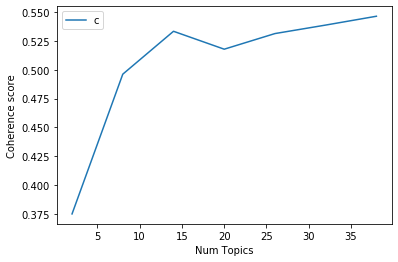

In [40]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [41]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 2))


Num Topics = 2  has Coherence Value of 0.37
Num Topics = 8  has Coherence Value of 0.5
Num Topics = 14  has Coherence Value of 0.53
Num Topics = 20  has Coherence Value of 0.52
Num Topics = 26  has Coherence Value of 0.53
Num Topics = 32  has Coherence Value of 0.54
Num Topics = 38  has Coherence Value of 0.55


In [42]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.015*"video" + 0.015*"system" + 0.013*"memory" + 0.013*"digital" + '
  '0.012*"drive" + 0.012*"pc" + 0.011*"feature" + 0.011*"power" + '
  '0.010*"notebook" + 0.010*"dvd"'),
 (1,
  '0.015*"create" + 0.012*"file" + 0.012*"tool" + 0.009*"software" + '
  '0.008*"design" + 0.008*"include" + 0.008*"professional" + 0.007*"document" '
  '+ 0.007*"work" + 0.007*"information"'),
 (2,
  '0.021*"collection" + 0.021*"diamond" + 0.016*"color" + '
  '0.014*"amazon_curate" + 0.012*"jewelry" + 0.010*"product" + '
  '0.010*"purchase" + 0.009*"stone" + 0.008*"clean" + 0.008*"piece"'),
 (3,
  '0.029*"image" + 0.023*"camera" + 0.015*"mode" + 0.014*"digital" + '
  '0.011*"photo" + 0.010*"video" + 0.009*"feature" + 0.008*"capture" + '
  '0.008*"color" + 0.008*"shoot"'),
 (4,
  '0.058*"div" + 0.024*"width" + 0.020*"bag" + 0.015*"height" + 0.010*"px" + '
  '0.008*"cover" + 0.008*"sleep" + 0.007*"offer" + 0.007*"jpg" + '
  '0.007*"div_boostcoltblt"'),
 (5,
  '0.031*"power" + 0.016*"system" + 0.014*"ba

In [27]:
#new code addition

In [29]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,17.0,0.6443,"make, world, life, time, new, first, take, get...","[hindery, ceo, network, new, york, yankee, cab..."
1,1,17.0,0.8004,"make, world, life, time, new, first, take, get...","[child, run, household, clinical_psychologist,..."
2,2,17.0,0.6634,"make, world, life, time, new, first, take, get...","[first, decade, mark, real, birth, american, p..."
3,3,17.0,0.6477,"make, world, life, time, new, first, take, get...","[godgiven, liberty, american, right, blast, go..."
4,4,17.0,0.2501,"make, world, life, time, new, first, take, get...","[div_classdisclaim, onlystrong, div, product_d..."
5,5,17.0,0.2114,"make, world, life, time, new, first, take, get...","[pbrget, fun, road, complete, full, workout, n..."
6,6,4.0,0.2123,"power, battery, vehicle, system, protection, i...","[mso_xml, wworddocument_wzoom, wdonotpromoteqf..."
7,7,17.0,0.3383,"make, world, life, time, new, first, take, get...","[div_classdisclaim, strong, nbspnbsp, div, pif..."
8,8,17.0,0.1896,"make, world, life, time, new, first, take, get...","[div_classdisclaim, div, prevashelf, help, mai..."
9,9,8.0,0.5799,"br, div, label, pp, product, px, amp, width, h...","[div_classdisclaim, package, product_descripti..."
